In [1]:
!pip install pymc

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


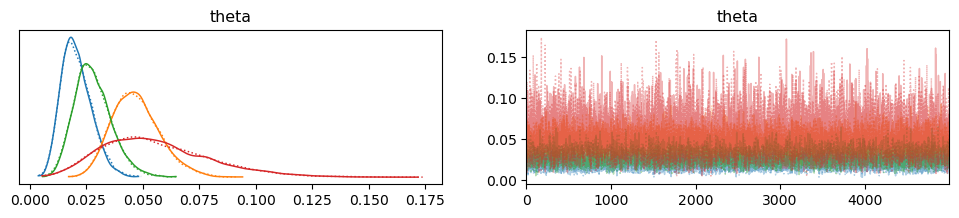

In [10]:
# 各デザイン案のクリック率を推論
# A 商品イメージ x 今すぐ購入
# B 商品イメージ x 詳しく見る
# C サンプル写真 x 今すぐ購入
# D サンプル写真 x 詳しく見る
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]

with pm.Model() as model:
    theta = pm.Uniform("theta", lower = 0, upper = 1, shape = len(n))
    obs = pm.Binomial("obs", p = theta, n = n, observed = clicks)
    trace = pm.sample(5000, chains = 2)
    pm.plot_trace(trace, compact = True)

In [11]:
with model:
    print(pm.summary(trace, hdi_prob = 0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.009      0.034        0.0      0.0   13737.0   
theta[1]  0.047  0.011     0.026      0.068        0.0      0.0   14239.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   12504.0   
theta[3]  0.056  0.024     0.015      0.104        0.0      0.0   14419.0   

          ess_tail  r_hat  
theta[0]    7533.0    1.0  
theta[1]    7715.0    1.0  
theta[2]    7472.0    1.0  
theta[3]    6731.0    1.0  


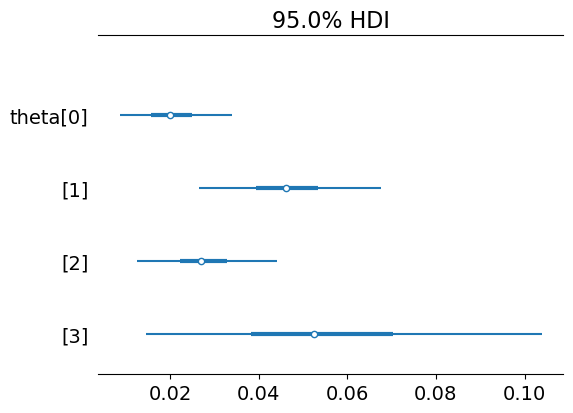

In [12]:
with model:
    pm.plot_forest(trace, combined = True, hdi_prob = 0.95)

In [13]:
print((trace.posterior["theta"][:, :, 1] - trace.posterior["theta"][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.9844)


In [14]:
print((trace.posterior["theta"][:, :, 3] - trace.posterior["theta"][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.9489)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


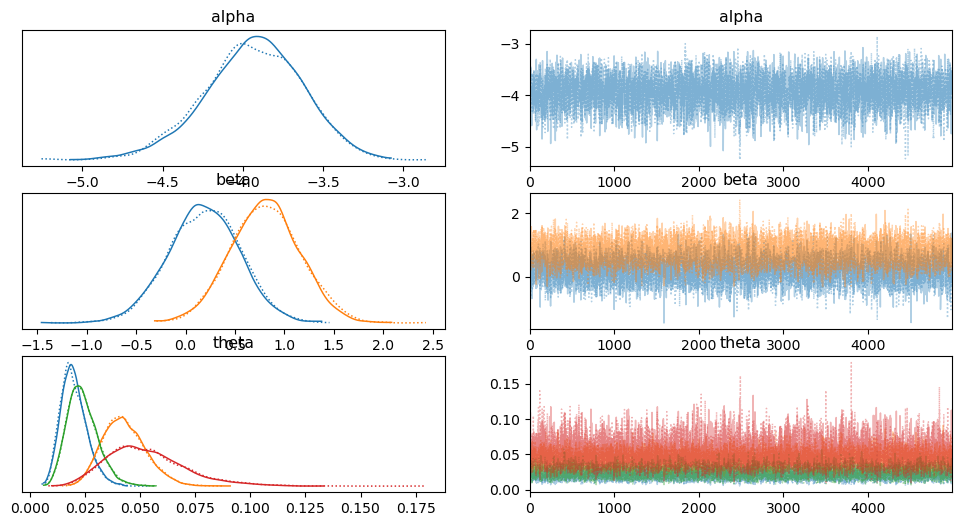

In [16]:
# ベースライン、画像、ボタンに要素を分解してロジスティック関数を使用
# ベースライン、画像、ボタンの事前分布は正規分布を使用
img = [0, 0, 1, 1]
btn = [0, 1, 0 ,1]

with pm.Model() as model_comb:
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial("obs", p = theta, n = n, observed = clicks)
    trace_comb = pm.sample(5000, chains = 2)
    pm.plot_trace(trace_comb)

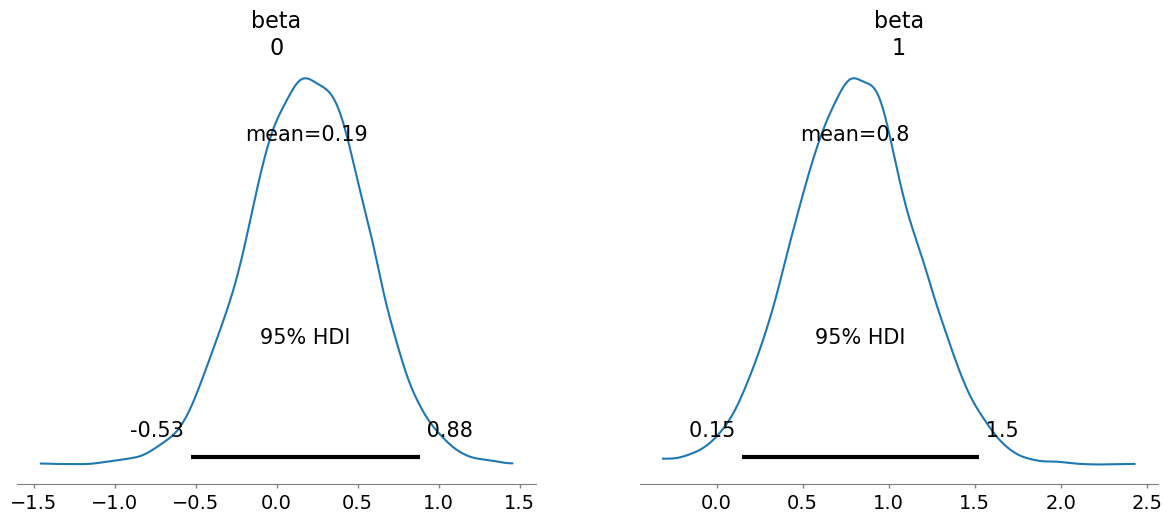

In [18]:
with model_comb:
    pm.plot_posterior(trace_comb, var_names = ["beta"], hdi_prob = 0.95)

In [28]:
print((trace_comb.posterior.beta[:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()> Size: 8B
array(0.9898)
Coordinates:
    beta_dim_0  int64 8B 1


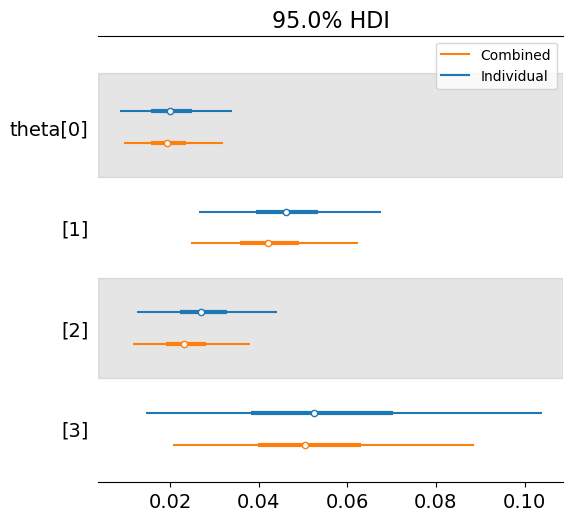

In [29]:
with pm.Model():
    pm.plot_forest([trace, trace_comb], var_names = ["theta"], hdi_prob = 0.95, combined = True, model_names = ["Individual", "Combined"])

In [31]:
print((trace_comb.posterior.theta[:, :, 1] - trace_comb.posterior.theta[:, :, 0] > 0).mean())
print((trace_comb.posterior.theta[:, :, 3] - trace_comb.posterior.theta[:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.9898)
<xarray.DataArray 'theta' ()> Size: 8B
array(0.9549)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


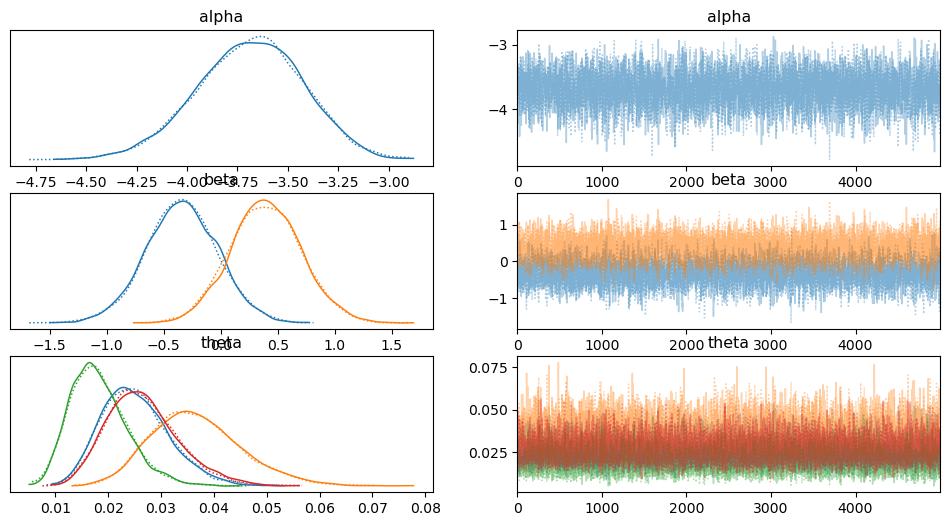

In [171]:
# レポートが更新された
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb2:
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial("obs", p = theta, n = n, observed = clicks)
    trace_comb2 = pm.sample(5000, chains = 2, idata_kwargs={"log_likelihood": True})
    pm.plot_trace(trace_comb2, compact = True)

In [172]:
print((trace_comb2.posterior.beta[:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()> Size: 8B
array(0.8964)
Coordinates:
    beta_dim_0  int64 8B 1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, gamma]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


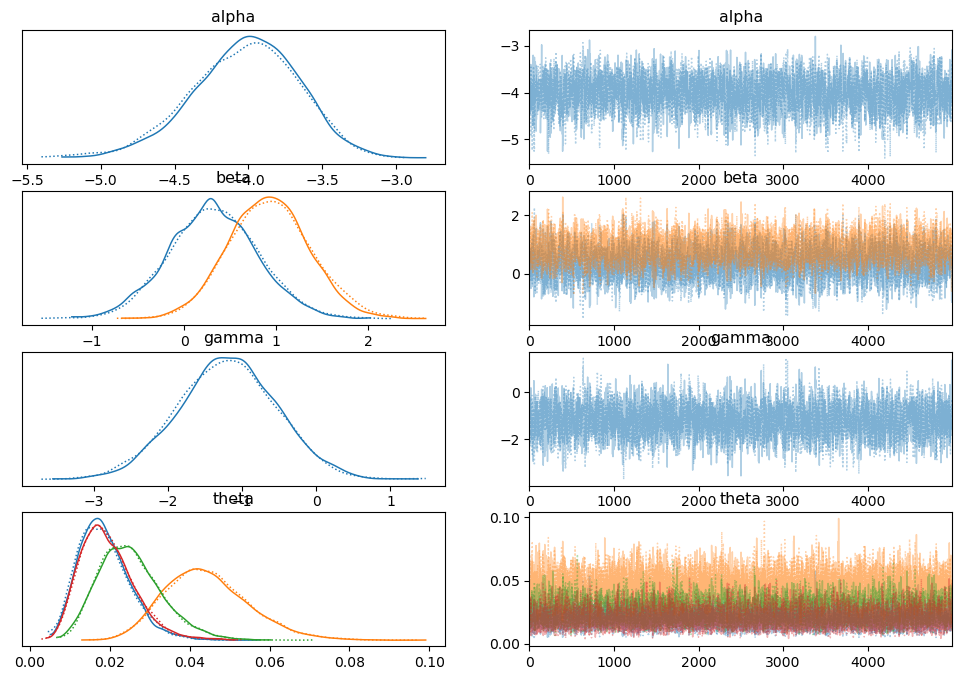

In [173]:
# 相互作用を考慮したモデル
# 相互作用項(γ)を追加
with pm.Model() as model_int:
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 2)
    gamma = pm.Normal("gamma", mu = 0, sigma = 10) # 追加
    comb = alpha + beta[0] * img + beta[1] * btn + gamma * img * btn # 変更
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial("obs", p = theta, n = n, observed = clicks)
    trace_int = pm.sample(5000, chains = 2, idata_kwargs={"log_likelihood": True})
    pm.plot_trace(trace_int, compact = True)

In [174]:
# 相互作用項の係数
print((trace_int.posterior.gamma.values < 0).mean())

0.9655


In [175]:
# ヒーロー画像の変更は、クリック率に正の効果があったとは認められない
print((trace_int.posterior.beta[:, :, 0] > 0).mean())
# CTAボタンの文言の変更は、クリック率に正の効果があった
print((trace_int.posterior.beta[:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()> Size: 8B
array(0.7449)
Coordinates:
    beta_dim_0  int64 8B 0
<xarray.DataArray 'beta' ()> Size: 8B
array(0.9833)
Coordinates:
    beta_dim_0  int64 8B 1


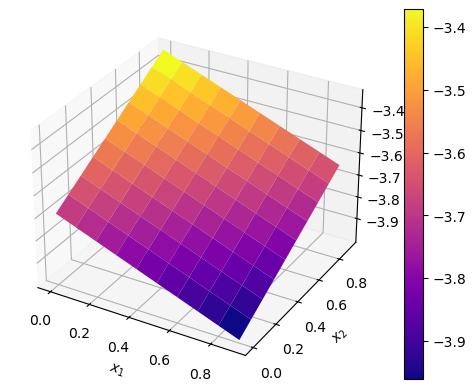

In [176]:
# 主効果のみのモデルCombinedの可視化
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
logit_theta = (trace_comb2.posterior.alpha.values.mean() +
               trace_comb2.posterior.beta[:, :, 0].values.mean() * X1 +
               trace_comb2.posterior.beta[:, :, 1].values.mean() * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap = "plasma")
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

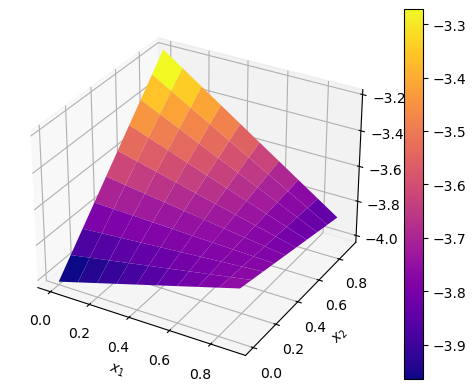

In [177]:
# 相互作用を含めたモデルInteractionの可視化
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
logit_theta = (trace_int.posterior.alpha.values.mean() +
               trace_int.posterior.beta[:, :, 0].values.mean() * X1 +
               trace_int.posterior.beta[:, :, 1].values.mean() * X2 +
               trace_int.posterior.gamma.values.mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap = "plasma")
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

In [181]:
# モデル選択のための指標であるWAICの算出
# 値が小さいものほど、良いモデルであることを表す
waic_comb2 = pm.waic(trace_comb2, model_comb2)
waic_int = pm.waic(trace_int, model_int)
print(waic_comb2.p_waic)
print(waic_int.p_waic)

3.5743853371796304
2.004575858729905


/opt/conda/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
